Exponential smoothing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import (ExponentialSmoothing,
                                 SimpleExpSmoothing,
                                 Holt,)
from data.oil_data import get_oil_data
from data.air_data import get_air_data
from data.aust_data import get_aust_data

Simple exponential Smoothing

In [2]:
oildata = get_oil_data()

/Users/pepijnschouten/Desktop/Python_Scripts/Python_scripts_Varia/Statsmodels_examples/timeseries/data/oil_data.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="1996", end="2008", freq="Y")


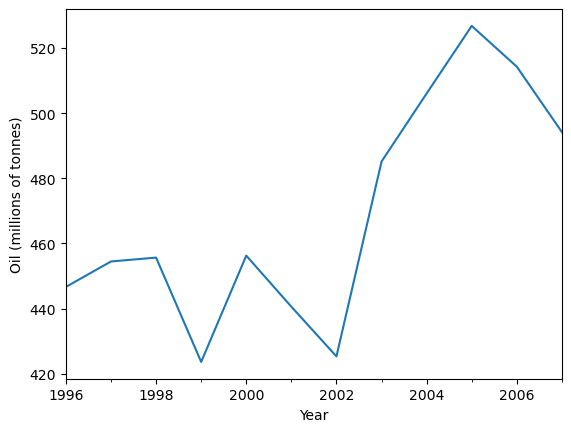

In [3]:
ax = oildata.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
plt.show()

In [4]:
fits, fcasts = [], []
for alpha in (0.2, 0.6, None):
    if alpha is None:
        fit = SimpleExpSmoothing(
            oildata,
            initialization_method="estimated").fit()
        fcast = fit.forecast(3).rename(
            f"alpha={fit.model.params['smoothing_level']}"
        )
    else:
        fit = SimpleExpSmoothing(
            oildata,
            initialization_method="heuristic",
            ).fit(smoothing_level=alpha, optimized=False
        )
        fcast = fit.forecast(3).rename(
            f"alpha={alpha}"
        )
    fits.append(fit)
    fcasts.append(fcast)   

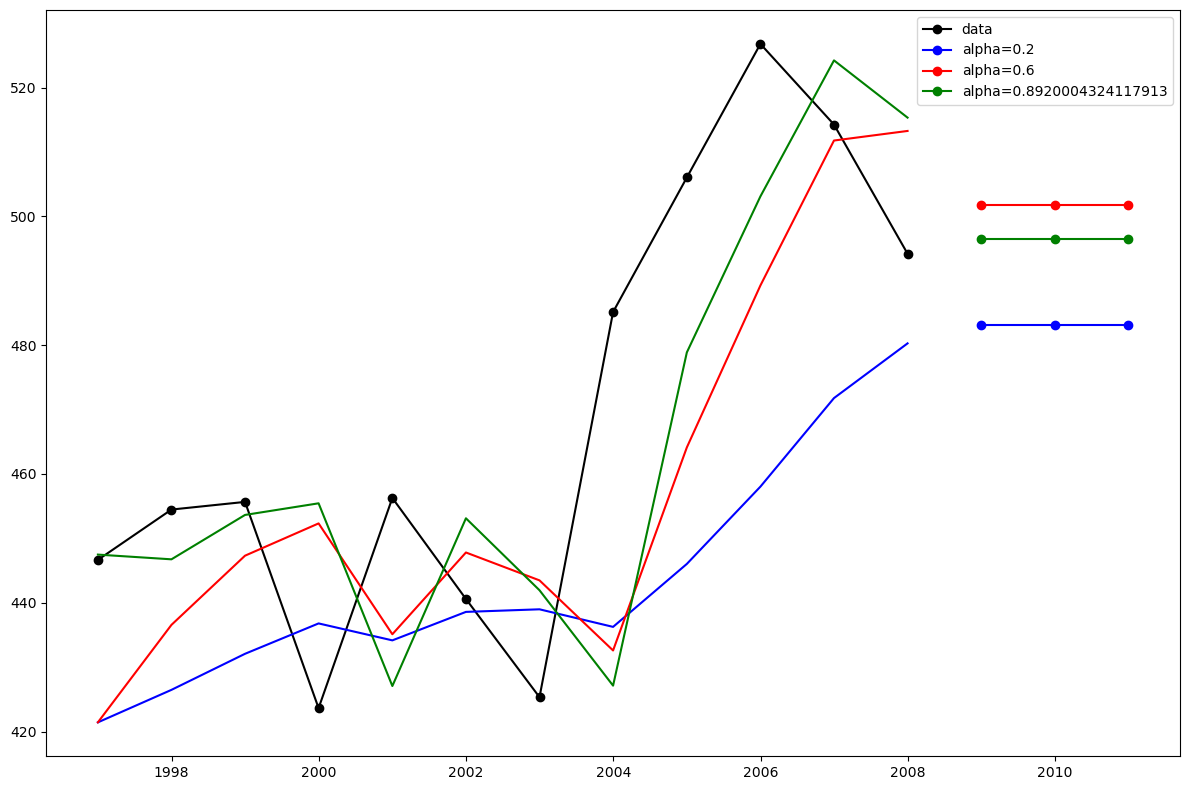

In [5]:
colors = ("blue", "red", "green")
plt.figure(figsize=(12, 8), dpi=100, tight_layout=True)
plt.plot(oildata, marker='o', color='black', label="data")
for fit, fcast, color in zip(fits, fcasts, colors):
    plt.plot(fit.fittedvalues, color=color)
    plt.plot(fcast, marker='o', color=color, label=fcast.name)
plt.legend()
plt.show()

Holt's Method

/Users/pepijnschouten/Desktop/Python_Scripts/Python_scripts_Varia/Statsmodels_examples/timeseries/data/air_data.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range(start="1990", end="2005", freq="Y")


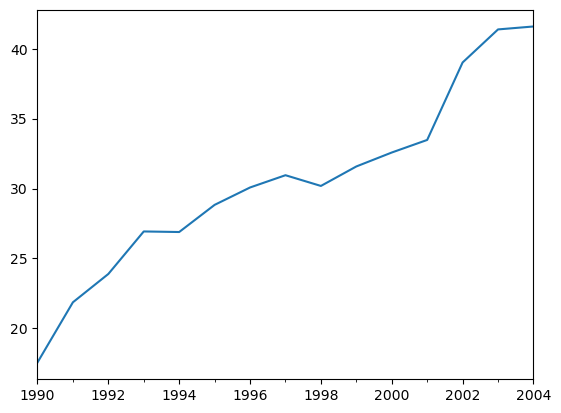

In [6]:
airdata = get_air_data()

ax = airdata.plot()
plt.show()

In [7]:
fit1 = Holt(airdata, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fit2 = Holt(airdata, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(5).rename("Exponential trend")
fit3 = Holt(airdata, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

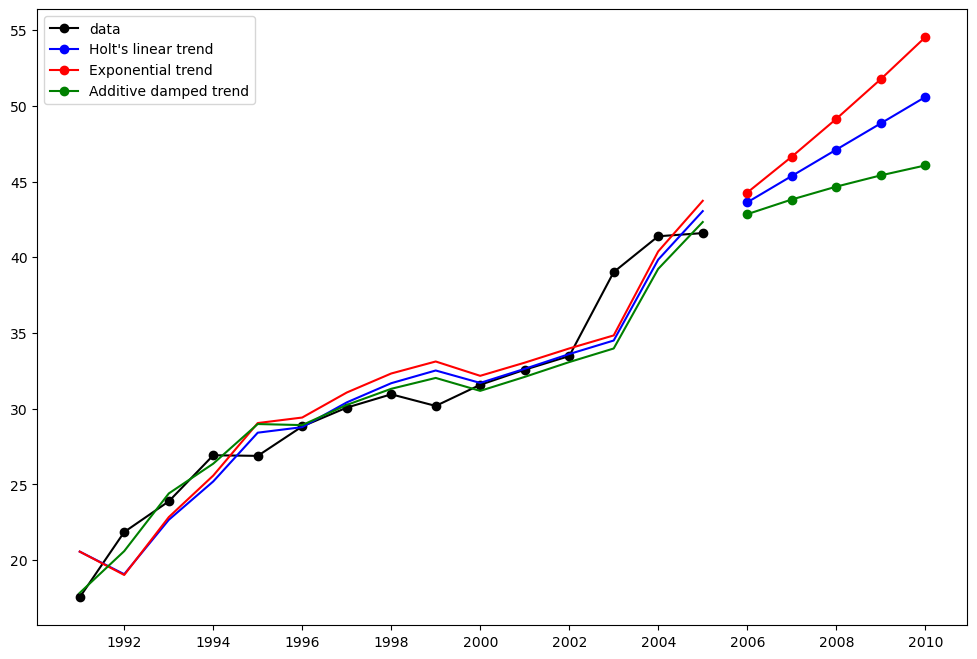

In [8]:
plt.figure(figsize=(12, 8))
(base,) = plt.plot(airdata, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([base, line1, line2, line3],
           ["data", fcast1.name, fcast2.name, fcast3.name])
plt.show()

Holts Seasonal (trend and seasonal component)

In [9]:
aust = get_aust_data()

In [10]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit3 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit4 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    damped_trend=True,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"] = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

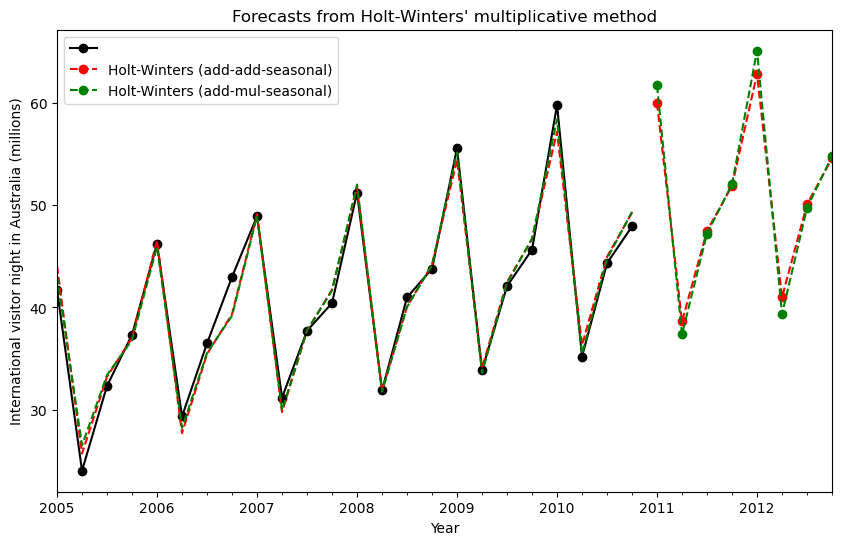

In [11]:
ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
    legend=True,
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()

Simulations and Confidence intervals

In [12]:
fit = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
).fit()

simulations = fit.simulate(
    8,
    repetitions=100,
    error='mul'
)


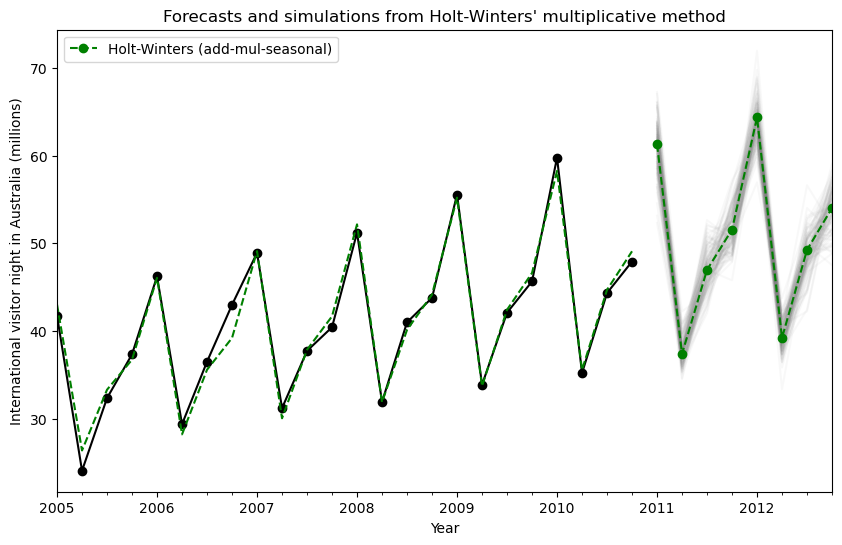

In [13]:
ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters' multiplicative method",
)
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)
plt.show()